In [1]:
%load_ext autoreload
%autoreload 2

In [13]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import stats
from scipy.integrate import quad
from scipy.interpolate import UnivariateSpline
import seaborn as sns
from scipy.special import factorial
import math
from iminuit import cost, Minuit 
import numpy as np
import pickle

sns.set_context('talk', font_scale=1.0)
sns.set_palette('colorblind')

from depth_helpers import *

datpath = '/home/cosilab/CalibrationData/CalibratedDATs/'
plot_dir = '/home/cosilab/CalibrationData/figures/'
CTD_sims = '/home/cosilab/COSITrapping/ctd_sims/CTD_HP414183.csv'
AC_sim_events = '/home/cosilab/COSITrapping/ctd_sims/am241_interactions_HP414183_ac.csv'
DC_sim_events = '/home/cosilab/COSITrapping/ctd_sims/am241_interactions_HP414183_dc.csv'
sim_dCCE = '/home/cosilab/COSITrapping/cce_sims/HP414183_dCCE_1000cm.csv'

fluence_list = [0., 2., 4.95, 4.95, 4.95]
temp_list = [80.5, 81.0, 81.2, 80.05, 79.9]
MJD_list = [60243., 60257., 60292., 60383., 60391.]
# MJD_cycle = [[60296., 60325.], [], []]

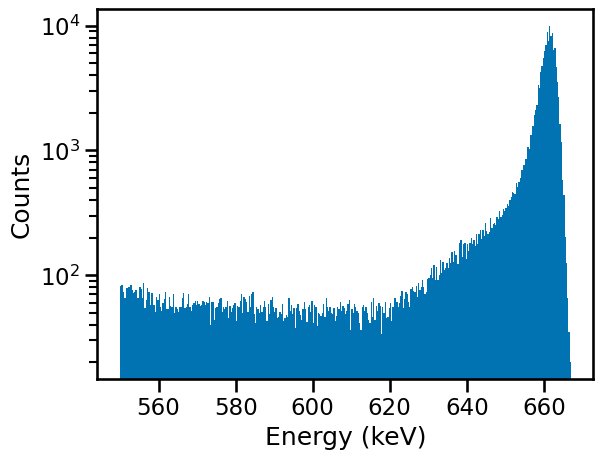

FWHM = 3.51
FWTM = 8.9


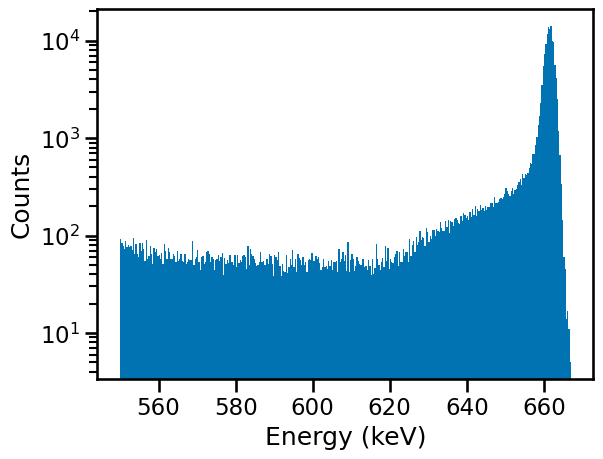

FWHM = 2.62
FWTM = 5.22


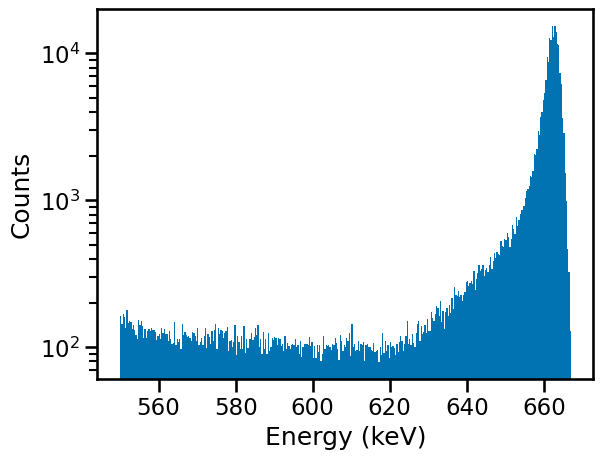

FWHM = 3.54
FWTM = 8.39


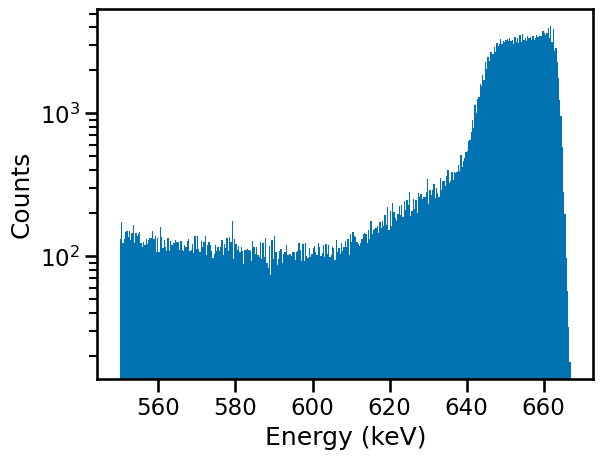

FWHM = 18.97
FWTM = 27.4


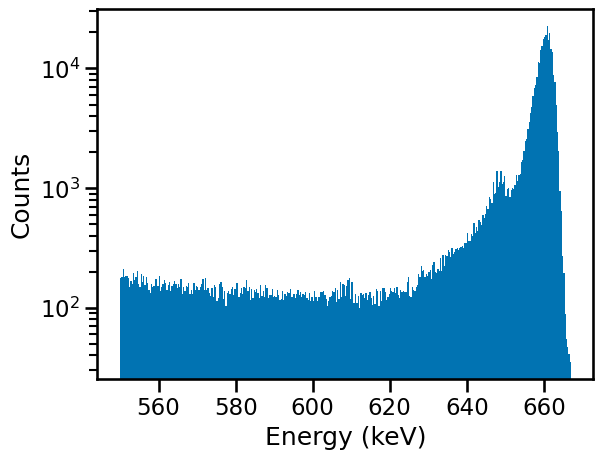

FWHM = 3.87
FWTM = 8.77


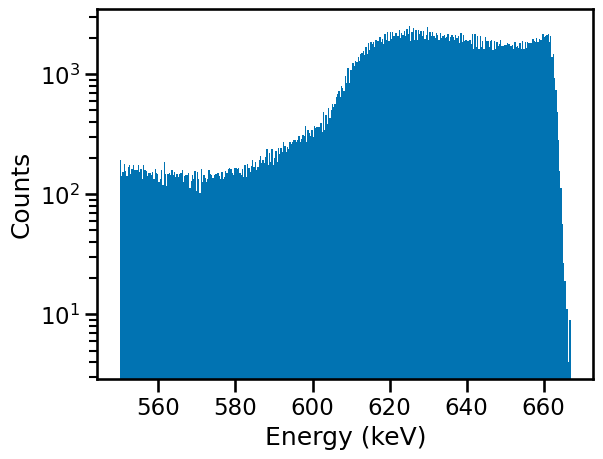

FWHM = 51.58
FWTM = 71.56


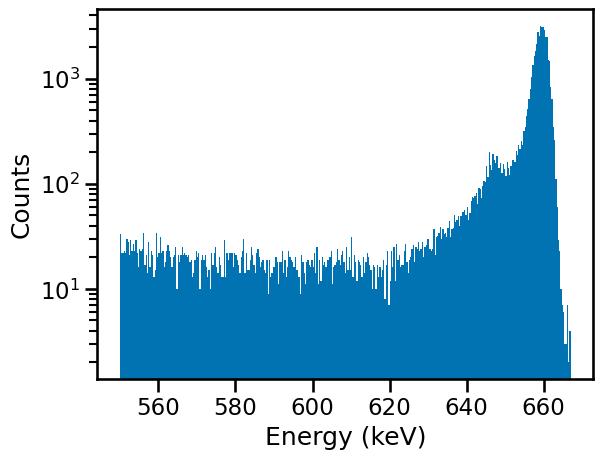

FWHM = 3.72
FWTM = 7.73


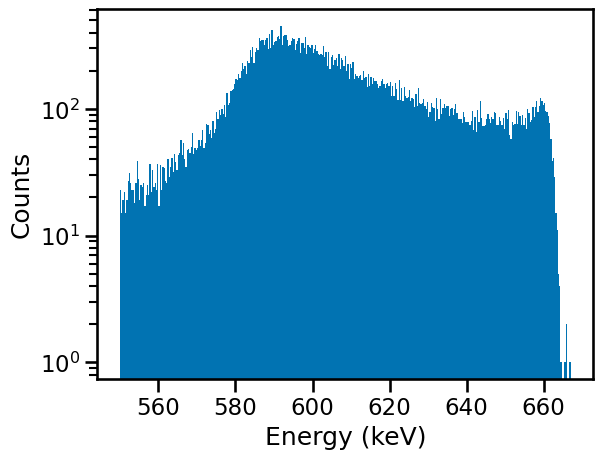

FWHM = 28.86
FWTM = 96.53


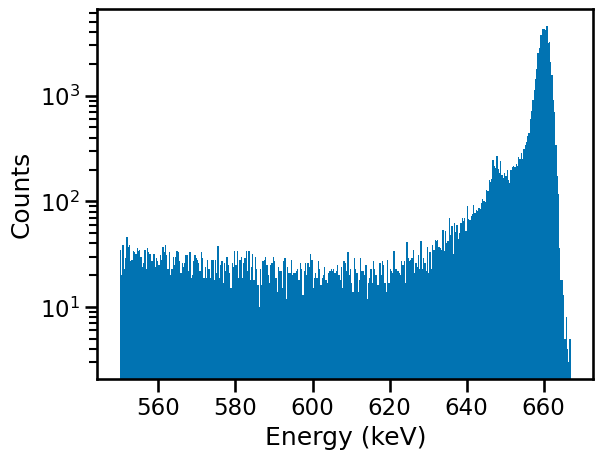

FWHM = 3.42
FWTM = 6.87


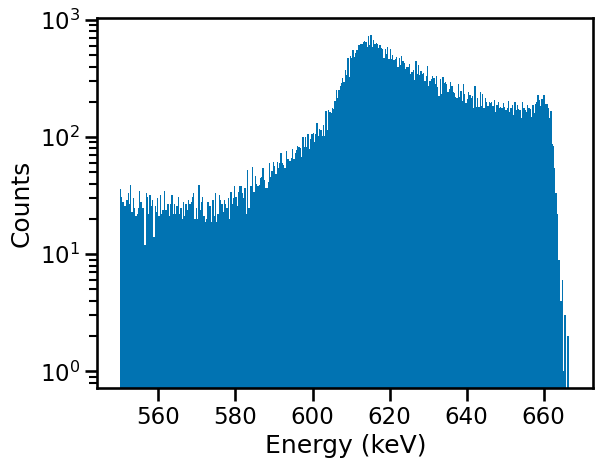

FWHM = 21.03
FWTM = 69.52


In [8]:
Cs_AC_dats = [['preLL/20231003_Cs137_AC_600V_1.dat', 'preLL/20231003_Cs137_AC_600V_2.dat', 'preLL/20231011_Cs137_AC_600V.dat', 'preLL/20231020_Cs137_AC_600V.dat'],\
              ['postLL1/20231030_Cs137_AC_600V.dat', 'postLL1/20231102_Cs137_AC_600V_1.dat', 'postLL1/20231031_Cs137_AC_600V.dat', 'postLL1/20231102_Cs137_AC_600V_2.dat', 'postLL1/20231101_Cs137_AC_600V.dat', 'postLL1/20231116_Cs137_AC_600V.dat'],\
              ['postLL2/20231120_Cs137_AC_600V.dat', 'postLL2/20231206_Cs137_AC_600V.dat', 'postLL2/20231127_Cs137_AC_600V.dat', 'postLL2/20231207_Cs137_AC_600V.dat', 'postLL2/20231204_Cs137_AC_600V.dat', 'postLL2/20231208_Cs137_AC_600V.dat', 'postLL2/20231205_Cs137_AC_600V.dat'],\
              ['postanneal1/20240312_Cs137_AC_600V.dat'],\
              ['postanneal2/20240322_Cs137_AC_600V.dat', 'postanneal2/20240321_Cs137_AC_600V.dat']]
emin = 550.
emax = 667.
fwhm_list = []
fwtm_list = []
for dats in Cs_AC_dats:
    
    fullpaths = []
    for p in dats:
        fullpaths.append(datpath + p)
    
    df = make_df_from_dat(fullpaths, e_min=emin, e_max=emax)
    bins = int((emax-emin) * 3)
    plt.figure()
    hist,binedges,_  = plt.hist(df['energy_p'], bins=bins, range=(emin, emax))
    plt.yscale('log')
    plt.xlabel('Energy (keV)')
    plt.ylabel('Counts')
    plt.show()
    
    fwhm_spline = UnivariateSpline(binedges[:-1], hist-0.5*np.max(hist))
    fwtm_spline = UnivariateSpline(binedges[:-1], hist-0.1*np.max(hist))
    fwhm = fwhm_spline.roots()[-1]-fwhm_spline.roots()[0]
    fwtm = fwtm_spline.roots()[-1]-fwtm_spline.roots()[0]
    print('FWHM = ' + str(round(fwhm, 2)))
    print('FWTM = ' + str(round(fwtm, 2)))

    plt.figure()
    hist,binedges,_  = plt.hist(df['energy_n'], bins=binedges)
    plt.yscale('log')
    plt.xlabel('Energy (keV)')
    plt.ylabel('Counts')
    plt.show()
    
    fwhm_spline = UnivariateSpline(binedges[:-1], hist-0.5*np.max(hist))
    fwtm_spline = UnivariateSpline(binedges[:-1], hist-0.1*np.max(hist))
    fwhm = fwhm_spline.roots()[-1]-fwhm_spline.roots()[0]
    fwtm = fwtm_spline.roots()[-1]-fwtm_spline.roots()[0]
    print('FWHM = ' + str(round(fwhm, 2)))
    print('FWTM = ' + str(round(fwtm, 2)))
    
    fwhm_list.append(fwhm)
    fwtm_list.append(fwtm)

In [9]:
AC_CTD_list = ['Am241_AC_preLL_57to62keV', 'Am241_AC_postLL1_57to62keV', 'Am241_AC_postLL2_57to62keV', 'Am241_AC_postanneal1_50to62keV', 'Am241_AC_postanneal2_50to62keV']
DC_CTD_list = ['Am241_DC_preLL_57to62keV', 'Am241_DC_postLL1_57to62keV', 'Am241_DC_postLL2_57to62keV', 'Am241_DC_postanneal1_50to62keV', 'Am241_DC_postanneal2_50to62keV']

slope_mean = []
slope_stdev = []
intercept_mean = []
intercept_stdev = []

calibrator_list = []

for i in range(len(AC_CTD_list)):
    AC_CTD = '/home/cosilab/CalibrationData/CTDs/'+AC_CTD_list[i]+'/CTD_parameters.txt'
    DC_CTD = '/home/cosilab/CalibrationData/CTDs/'+DC_CTD_list[i]+'/CTD_parameters.txt'
    calibrator = DepthCalibrator_Am241(AC_CTD, DC_CTD, AC_sim_events, DC_sim_events, CTD_sims)
    calibrator_list.append(calibrator)
    slope_mean.append(np.nanmean(calibrator.slope.flatten()))
    slope_stdev.append(np.nanstd(calibrator.slope.flatten()))
    intercept_mean.append(np.nanmean(calibrator.intercept.flatten()))
    intercept_stdev.append(np.nanstd(calibrator.intercept.flatten()))
    
    plt.figure()
    plt.hist(calibrator.slope.flatten(), bins=50, range=(0.75, 1.0))
    plt.ylabel('Pixels')
    plt.xlabel('Stretch factor')
    plt.tight_layout()
    # plt.show()
    plt.savefig(plot_dir + AC_CTD_list[i].split('_')[2] + '_stretch_dist.pdf')
    plt.close()
    
    plt.figure()
    plt.hist(calibrator.intercept.flatten(), bins=50, range=(-75,25))
    plt.ylabel('Pixels')
    plt.xlabel('Offset')
    plt.tight_layout()
    # plt.show()
    plt.savefig(plot_dir + AC_CTD_list[i].split('_')[2] + 'offset_dist.pdf')
    plt.close()

print(slope_mean)
print(intercept_mean)

/home/cosilab/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/cosilab/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/cosilab/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/cosilab/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/cosilab/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/cosilab/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountere

[0.892859368936289, 0.8971698626028238, 0.9233423088815423, 0.9505954143336933, 0.9447525011451594]
[-13.249083889505581, -13.904860205871929, -11.210585663849896, -14.70596814105488, -13.863876589584905]


In [21]:
plt.figure()
plt.errorbar(fluence_list, slope_mean, yerr=slope_stdev)
plt.xlabel('fluence (10^8 p/cm2)')
plt.ylabel('Stretch factor')
plt.tight_layout()
# plt.show()
plt.savefig(plot_dir + 'stretch_fluence.pdf')
plt.close()

plt.figure()
plt.errorbar(fluence_list, intercept_mean, yerr=intercept_stdev)
plt.xlabel('fluence (10^8 p/cm2)')
plt.ylabel('Offset')
plt.tight_layout()
# plt.show()
plt.savefig(plot_dir + 'offset_fluence.pdf')
plt.close()

plt.figure()
plt.boxplot([calibrator_list[i].slope.flatten()[~np.isnan(calibrator_list[i].slope.flatten())] for i in range(len(fluence_list))], positions=fluence_list)
plt.ylabel('Stretch factor')
plt.xlabel('fluence (10^8 p/cm2)')
plt.tight_layout()
# plt.show()
plt.savefig(plot_dir + 'stretch_fluence_box.pdf')
plt.close()

plt.figure()
plt.boxplot([calibrator_list[i].intercept.flatten()[~np.isnan(calibrator_list[i].intercept.flatten())] for i in range(len(fluence_list))], positions=fluence_list)
plt.ylabel('Offset')
plt.xlabel('fluence (10^8 p/cm2)')
plt.tight_layout()
# plt.show()
plt.savefig(plot_dir + 'offset_fluence_box.pdf')
plt.close()

In [21]:
plt.figure()
plt.errorbar(temp_list, slope_mean, yerr=slope_stdev)
plt.xlabel('temperature (K)')
plt.ylabel('Stretch factor')
plt.tight_layout()
# plt.show()
plt.savefig(plot_dir + 'stretch_temp.pdf')
plt.close()

plt.figure()
plt.errorbar(temp_list, intercept_mean, yerr=intercept_stdev)
plt.xlabel('temperature (K)')
plt.ylabel('Offset')
plt.tight_layout()
# plt.show()
plt.savefig(plot_dir + 'offset_temp.pdf')
plt.close()

plt.figure()
plt.boxplot([calibrator_list[i].slope.flatten()[~np.isnan(calibrator_list[i].slope.flatten())] for i in range(len(temp_list))], positions=temp_list)
plt.ylabel('Stretch factor')
plt.xlabel('temperature (K)')
plt.tight_layout()
# plt.show()
plt.savefig(plot_dir + 'stretch_temp_box.pdf')
plt.close()

plt.figure()
plt.boxplot([calibrator_list[i].intercept.flatten()[~np.isnan(calibrator_list[i].intercept.flatten())] for i in range(len(temp_list))], positions=temp_list)
plt.ylabel('Offset')
plt.xlabel('temperature (K)')
plt.tight_layout()
# plt.show()
plt.savefig(plot_dir + 'offset_temp_box.pdf')
plt.close()

In [10]:
plt.figure()
plt.errorbar(fwhm_list, slope_mean, yerr=slope_stdev)
plt.xlabel('FWHM (keV)')
plt.ylabel('Stretch factor')
plt.tight_layout()
# plt.show()
plt.savefig(plot_dir + 'stretch_fwhm.pdf')
plt.close()

plt.figure()
plt.errorbar(fwhm_list, intercept_mean, yerr=intercept_stdev)
plt.xlabel('FWHM (keV)')
plt.ylabel('Offset')
plt.tight_layout()
# plt.show()
plt.savefig(plot_dir + 'offset_fwhm.pdf')
plt.close()

plt.figure()
plt.boxplot([calibrator_list[i].slope.flatten()[~np.isnan(calibrator_list[i].slope.flatten())] for i in range(len(fwhm_list))], positions=fwhm_list)
plt.ylabel('Stretch factor')
plt.xlabel('FWHM (keV)')
plt.tight_layout()
# plt.show()
plt.savefig(plot_dir + 'stretch_fwhm_box.pdf')
plt.close()

plt.figure()
plt.boxplot([calibrator_list[i].intercept.flatten()[~np.isnan(calibrator_list[i].intercept.flatten())] for i in range(len(fwhm_list))], positions=fwhm_list)
plt.ylabel('Offset')
plt.xlabel('FWHM (keV)')
plt.tight_layout()
# plt.show()
plt.savefig(plot_dir + 'offset_fwhm_box.pdf')
plt.close()

In [11]:
plt.figure()
plt.errorbar(fwtm_list, slope_mean, yerr=slope_stdev)
plt.xlabel('FWTM (keV)')
plt.ylabel('Stretch factor')
plt.tight_layout()
# plt.show()
plt.savefig(plot_dir + 'stretch_fwtm.pdf')
plt.close()

plt.figure()
plt.errorbar(fwtm_list, intercept_mean, yerr=intercept_stdev)
plt.xlabel('FWTM (keV)')
plt.ylabel('Offset')
plt.tight_layout()
# plt.show()
plt.savefig(plot_dir + 'offset_fwtm.pdf')
plt.close()

plt.figure()
plt.boxplot([calibrator_list[i].slope.flatten()[~np.isnan(calibrator_list[i].slope.flatten())] for i in range(len(fwtm_list))], positions=fwtm_list)
plt.ylabel('Stretch factor')
plt.xlabel('FWTM (keV)')
plt.tight_layout()
# plt.show()
plt.savefig(plot_dir + 'stretch_fwtm_box.pdf')
plt.close()

plt.figure()
plt.boxplot([calibrator_list[i].intercept.flatten()[~np.isnan(calibrator_list[i].intercept.flatten())] for i in range(len(fwtm_list))], positions=fwtm_list)
plt.ylabel('Offset')
plt.xlabel('FWTM (keV)')
plt.tight_layout()
# plt.show()
plt.savefig(plot_dir + 'offset_fwtm_box.pdf')
plt.close()

In [12]:
ratio_list = np.array(fwhm_list)/np.array(fwtm_list)
plt.figure()
plt.errorbar(ratio_list, slope_mean, yerr=slope_stdev)
plt.xlabel('FWHM/FWTM')
plt.ylabel('Stretch factor')
plt.tight_layout()
# plt.show()
plt.savefig(plot_dir + 'stretch_ratio.pdf')
plt.close()

plt.figure()
plt.errorbar(ratio_list, intercept_mean, yerr=intercept_stdev)
plt.xlabel('FWHM/FWTM')
plt.ylabel('Offset')
plt.tight_layout()
# plt.show()
plt.savefig(plot_dir + 'offset_ratio.pdf')
plt.close()

plt.figure()
plt.boxplot([calibrator_list[i].slope.flatten()[~np.isnan(calibrator_list[i].slope.flatten())] for i in range(len(ratio_list))], positions=ratio_list)
plt.ylabel('Stretch factor')
plt.xlabel('FWHM/FWTM')
plt.tight_layout()
# plt.show()
plt.savefig(plot_dir + 'stretch_ratio_box.pdf')
plt.close()

plt.figure()
plt.boxplot([calibrator_list[i].intercept.flatten()[~np.isnan(calibrator_list[i].intercept.flatten())] for i in range(len(ratio_list))], positions=ratio_list)
plt.ylabel('Offset')
plt.xlabel('FWHM/FWTM')
plt.tight_layout()
# plt.show()
plt.savefig(plot_dir + 'offset_ratio_box.pdf')
plt.close()

In [14]:
plt.figure()
plt.errorbar(MJD_list, slope_mean, yerr=slope_stdev)
plt.xlabel('MJD')
plt.ylabel('Stretch factor')
plt.tight_layout()
# plt.show()
plt.savefig(plot_dir + 'stretch_MJD.pdf')
plt.close()

plt.figure()
plt.errorbar(MJD_list, intercept_mean, yerr=intercept_stdev)
plt.xlabel('MJD')
plt.ylabel('Offset')
plt.tight_layout()
# plt.show()
plt.savefig(plot_dir + 'offset_MJD.pdf')
plt.close()

